In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import openmeteo_requests
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.714,
	"longitude": -74.006,
	"start_date": "2020-01-01",
	"end_date": "2021-04-30",
	"hourly": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation", "rain", "snowfall", "snow_depth", "cloud_cover_low", "wind_speed_10m", "wind_gusts_10m"],
	"timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
hourly_rain = hourly.Variables(4).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(5).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(6).ValuesAsNumpy()
hourly_cloud_cover_low = hourly.Variables(7).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(8).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(9).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s"),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

hourly_dataframe_2020 = pd.DataFrame(data = hourly_data)

Coordinates 40.738136291503906°E -74.04254150390625°N
Elevation 37.0 m asl
Timezone b'America/New_York' b'EST'
Timezone difference to GMT+0 -18000 s


In [3]:
tlc_20_01 = pd.read_parquet('raw_data/fhvhv_tripdata_2020-01.parquet')
tlc_20_02 = pd.read_parquet('raw_data/fhvhv_tripdata_2020-02.parquet')
tlc_20_03 = pd.read_parquet('raw_data/fhvhv_tripdata_2020-03.parquet')
tlc_20_04 = pd.read_parquet('raw_data/fhvhv_tripdata_2020-04.parquet')

In [4]:
tlc_21_01 = pd.read_parquet('raw_data/fhvhv_tripdata_2021-01.parquet')
tlc_21_02 = pd.read_parquet('raw_data/fhvhv_tripdata_2021-02.parquet')
tlc_21_03 = pd.read_parquet('raw_data/fhvhv_tripdata_2021-03.parquet')
tlc_21_04 = pd.read_parquet('raw_data/fhvhv_tripdata_2021-04.parquet')

In [5]:
columns = ['pickup_datetime','trip_miles', 'trip_time']

tlc_20_01 = tlc_20_01[columns]
tlc_20_02 = tlc_20_02[columns]
tlc_20_03 = tlc_20_03[columns]
tlc_20_04 = tlc_20_04[columns]

tlc_21_01 = tlc_21_01[columns]
tlc_21_02 = tlc_21_02[columns]
tlc_21_03 = tlc_21_03[columns]
tlc_21_04 = tlc_21_04[columns]

In [6]:
# Unir los DataFrames
merged_20 = pd.concat([tlc_20_01, tlc_20_02, tlc_20_03, tlc_20_04], ignore_index=True)
merged_21 = pd.concat([tlc_21_01, tlc_21_02, tlc_21_03, tlc_21_04], ignore_index=True)

In [7]:
merged_20 = merged_20.sort_values(by='pickup_datetime')
merged_21 = merged_21.sort_values(by='pickup_datetime')

In [8]:
merged_20.reset_index(drop=True, inplace=True)
merged_21.reset_index(drop=True, inplace=True)

In [9]:
semanal_taxi_20 = merged_20.resample('W', on = 'pickup_datetime').mean()
semanal_taxi_21 = merged_21.resample('W', on = 'pickup_datetime').mean()

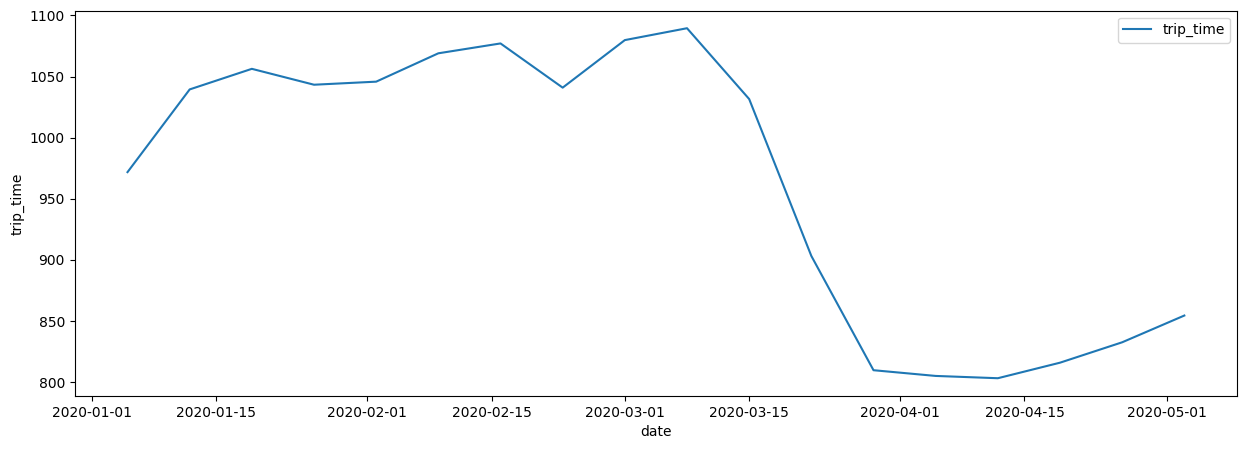

In [10]:
plt.figure(figsize = (15,5))

plt.plot(semanal_taxi_20.index, semanal_taxi_20.trip_time, label = 'trip_time')
plt.xlabel('date')
plt.ylabel('trip_time')
plt.legend()
plt.show()

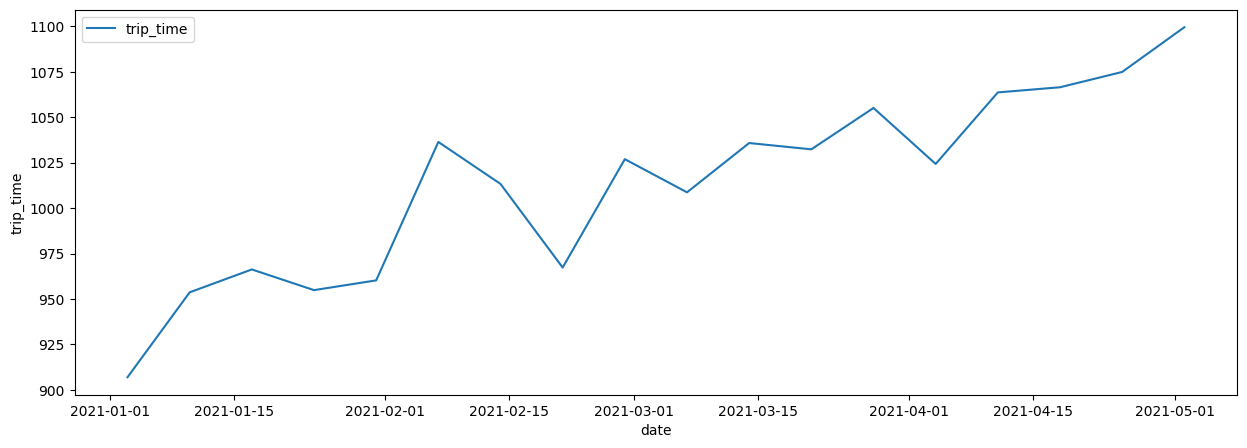

In [11]:
plt.figure(figsize = (15,5))

plt.plot(semanal_taxi_21.index, semanal_taxi_21.trip_time, label = 'trip_time')
plt.xlabel('date')
plt.ylabel('trip_time')
plt.legend()
plt.show()

In [13]:
hourly_dataframe_2020.head()

,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,cloud_cover_low,wind_speed_10m,wind_gusts_10m
0,2020-01-01 05:00:00,3.0635,73.918938,-1.807430,0.0,0.0,0.0,0.0,0.0,17.673029,29.160000
1,2020-01-01 06:00:00,1.9135,76.475830,-2.886475,0.0,0.0,0.0,0.0,0.0,16.559999,29.160000
2,2020-01-01 07:00:00,1.4135,78.969551,-3.394002,0.0,0.0,0.0,0.0,0.0,16.563911,27.719999
3,2020-01-01 08:00:00,1.0635,76.899399,-4.152611,0.0,0.0,0.0,0.0,0.0,18.723459,31.680000
4,2020-01-01 09:00:00,0.7135,76.272102,-4.358851,0.0,0.0,0.0,0.0,0.0,17.339897,31.319998


In [15]:
df_w_2020 = hourly_dataframe_2020[(hourly_dataframe_2020['date'] >= '2020-01-01') 
                                  & (hourly_dataframe_2020['date'] <= '2020-04-30')]

df_w_2021 = hourly_dataframe_2020[(hourly_dataframe_2020['date'] >= '2021-01-01') 
                                  & (hourly_dataframe_2020['date'] <= '2021-04-30')]

In [18]:
semanal_w_20 = df_w_2020.resample('W', on = 'date').mean()
semanal_w_21 = df_w_2021.resample('W', on = 'date').mean()

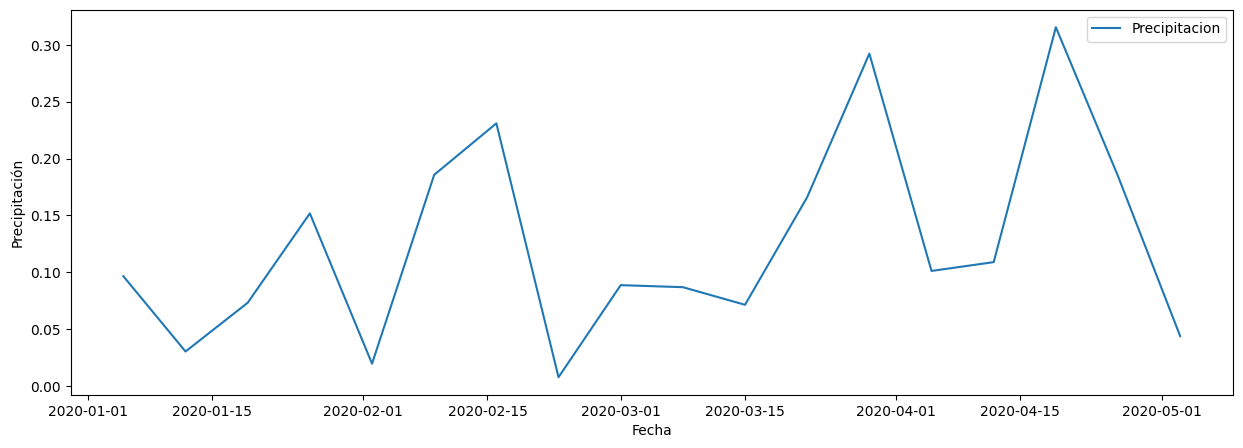

In [19]:
plt.figure(figsize = (15,5))

plt.plot(semanal_w_20.index, semanal_w_20.precipitation, label = 'Precipitacion')
plt.xlabel('Fecha')
plt.ylabel('Precipitación')
plt.legend()
plt.show()

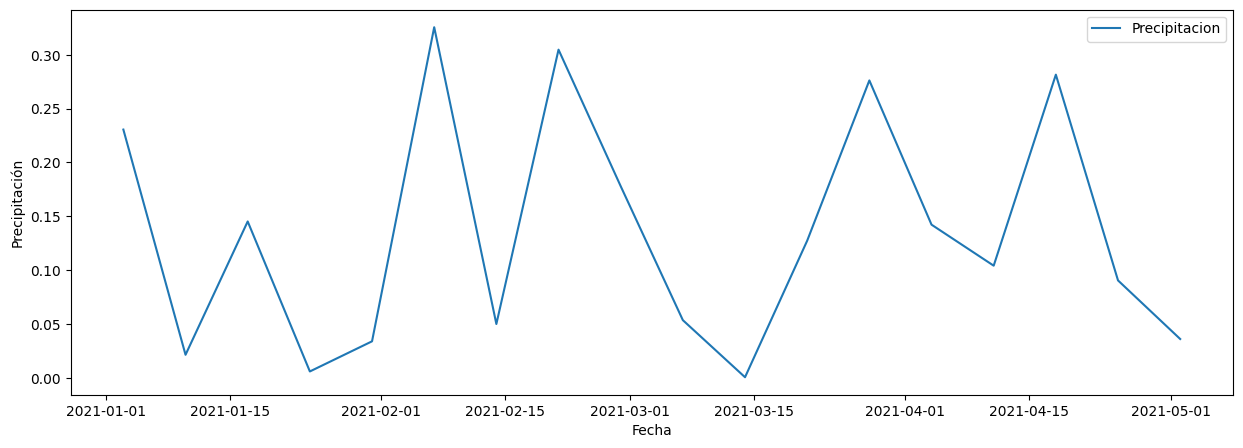

In [20]:
plt.figure(figsize = (15,5))

plt.plot(semanal_w_21.index, semanal_w_21.precipitation, label = 'Precipitacion')
plt.xlabel('Fecha')
plt.ylabel('Precipitación')
plt.legend()
plt.show()

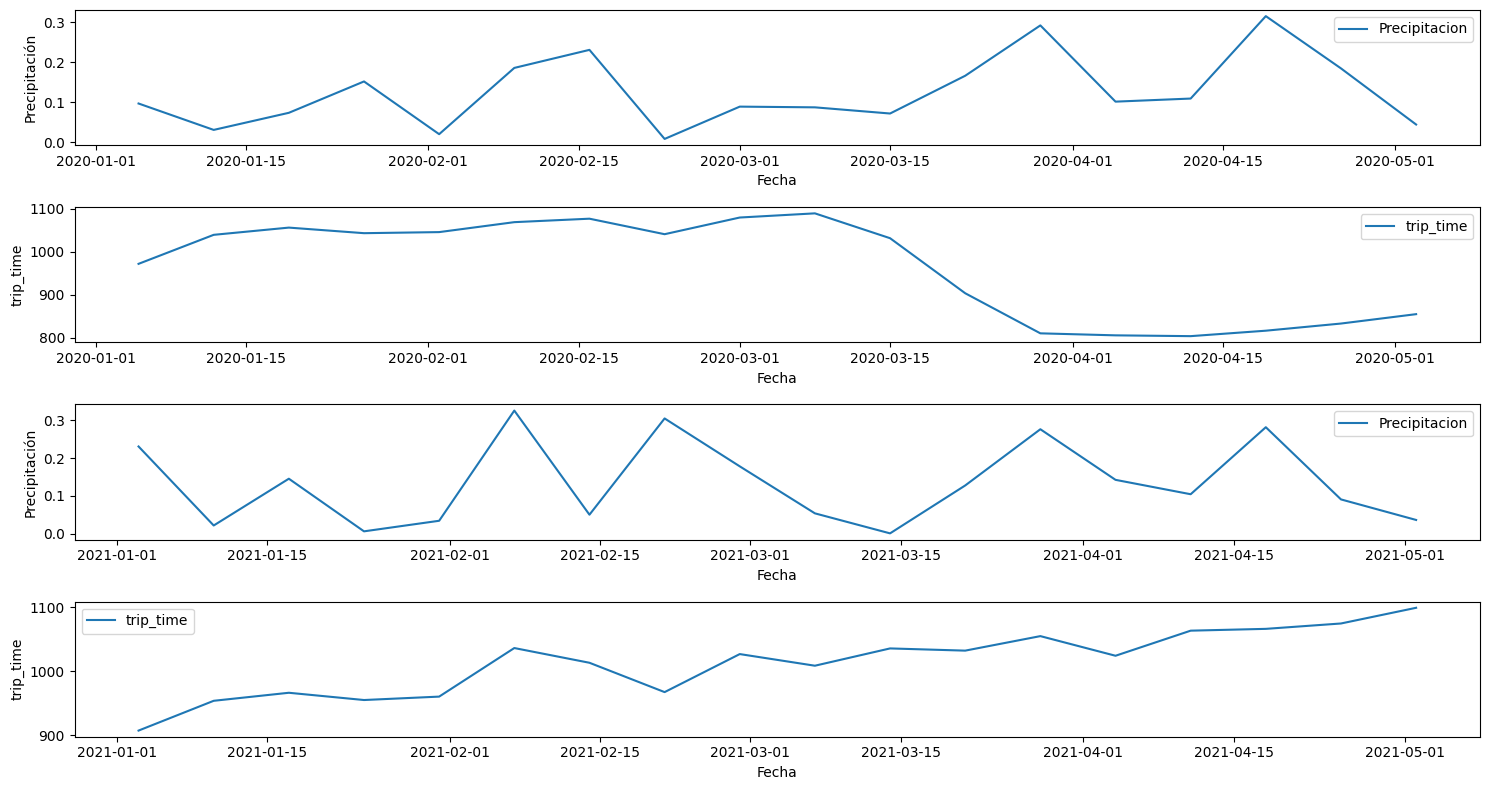

In [22]:
plt.figure(figsize=(15, 8))

# Primer gráfico
plt.subplot(4, 1, 1)  # 2 filas, 1 columna, primer subgráfico
plt.plot(semanal_w_20.index, semanal_w_20.precipitation, label='Precipitacion')
plt.xlabel('Fecha')
plt.ylabel('Precipitación')
plt.legend()

# Segundo gráfico
plt.subplot(4, 1, 2)  # 2 filas, 1 columna, segundo subgráfico
plt.plot(semanal_taxi_20.index, semanal_taxi_20.trip_time, label='trip_time')
plt.xlabel('Fecha')
plt.ylabel('trip_time')
plt.legend()

# Tercer gráfico
plt.subplot(4, 1, 3)  # 2 filas, 1 columna, primer subgráfico
plt.plot(semanal_w_21.index, semanal_w_21.precipitation, label='Precipitacion')
plt.xlabel('Fecha')
plt.ylabel('Precipitación')
plt.legend()


# Cuarto gráfico
plt.subplot(4, 1, 4)  # 2 filas, 1 columna, segundo subgráfico
plt.plot(semanal_taxi_21.index, semanal_taxi_21.trip_time, label='trip_time')
plt.xlabel('Fecha')
plt.ylabel('trip_time')
plt.legend()


plt.tight_layout()  # Ajusta automáticamente los espacios para evitar solapamiento
plt.show()
